In [5]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report

# Read the Data

In [6]:
working_directory = os.getcwd()
print(working_directory)
data = pd.read_csv(f"{working_directory}/Input_Data/creditcard_post_correlation.csv") #Change the path to your dataset, if needed

c:\Users\teovr\Desktop\Projects\Predicting_Fraudulent_Transactions_With_Machine_Learning


## Define Predictors and Target Variables
##### We will specify the predictor features and the target variable. Additionally, categorical features can be identified if present. In this case, there are no categorical features.



In [7]:
# Define the target variable
target = 'Fraud_Flag'

# Define the features to be used in the model
predictors = [
    'Transaction_Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
    'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
    'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
    'Transaction_Amount'
]

## Define the TRAIN/VALIDATION/TEST SPLIT

In [ ]:
#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2018

# Set the path to the input data
IS_LOCAL = True  # Set to True since you we running locally

if IS_LOCAL:
    PATH = (f"{working_directory}/Input_Data/")
else:
    PATH = "../input"

print(os.listdir(PATH))  # List the files in the specified directory

['creditcard.csv', 'creditcard.rar', 'creditcard_cleaned.csv', 'creditcard_post_correlation.csv', 'creditcard_post_exploration.csv', 'download_data_link.txt']


## Split data in train, test and validation set

In [10]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(
    data, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    shuffle=True
)

# Further split the training set into training and validation sets
train_df, valid_df = train_test_split(
    train_df, 
    test_size=VALID_SIZE, 
    random_state=RANDOM_STATE, 
    shuffle=True
)

## Random Forest Classifier

##### We are going to start with a RandomForrestClassifier model.
##### Let's set the parameters for the model.

### Random Forrest Classifier definitions

In [11]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NUMBER_OF_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

#### The model will be trained using the training set and evaluated on the validation set.

#### The GINI coefficient, calculated as GINI = 2 * (AUC) - 1 (where AUC is the Area Under the Receiver Operating Characteristic Curve), will be used as the validation metric. The number of estimators is set to 100, and the model will utilize 4 parallel jobs.

#### The process begins by initializing the Random Forest Classifier.

In [12]:
# Initialize the RandomForestClassifier
clf = RandomForestClassifier(
    n_jobs=NUMBER_OF_JOBS,       # Number of parallel jobs
    random_state=RANDOM_STATE,   # Random seed for reproducibility
    criterion=RFC_METRIC,        # Splitting criterion (e.g., 'gini')
    n_estimators=NUM_ESTIMATORS, # Number of trees in the forest
    verbose=False                # Suppress verbose output
)

##### Train the Randon Forest Classifier using the train_df data and fit function.

In [13]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

##### Use the predict function to predict the target values for the valid_df data.

In [14]:
predictions = clf.predict(valid_df[predictors])

##### We will also visualize the features importance.

### Features importance

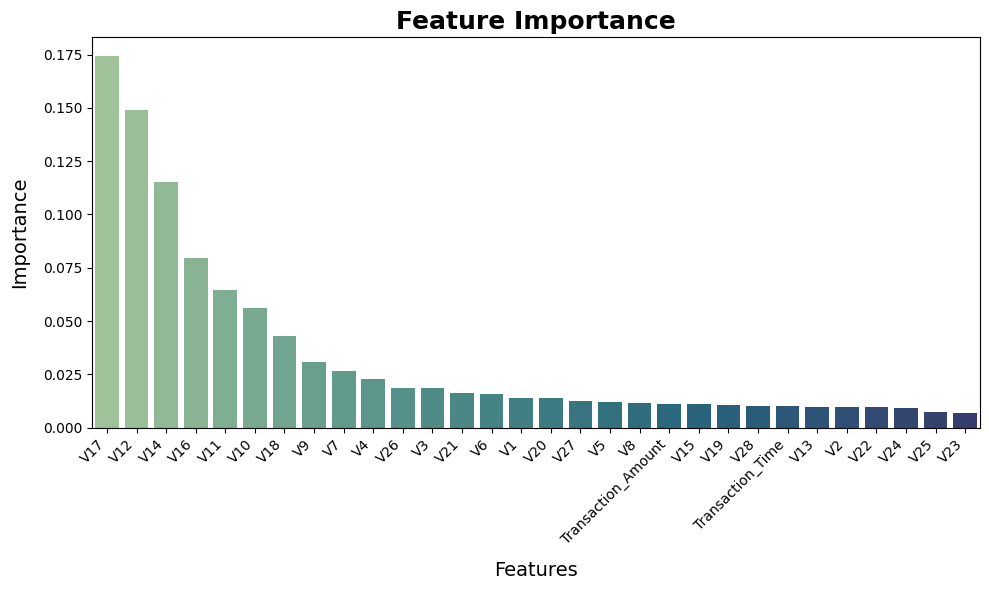

In [15]:
# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({
    'Feature': predictors,
    'Importance': clf.feature_importances_
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.title('Feature Importance', fontsize=18, fontweight='bold')
sns.barplot(
    x='Feature',
    y='Importance',
    hue='Feature',  
    data=feature_importance_df,
    palette='crest',  
    dodge=False  
)
plt.legend([], [], frameon=False)  
plt.xticks(rotation=45, fontsize=10, ha='right')
plt.xlabel('Features', fontsize=14, labelpad=10)
plt.ylabel('Importance', fontsize=14, labelpad=10)
plt.tight_layout()  
plt.show() 

##### The most important features are V17, V12, V14, V10, V11, V16.

### Confusion Matrix

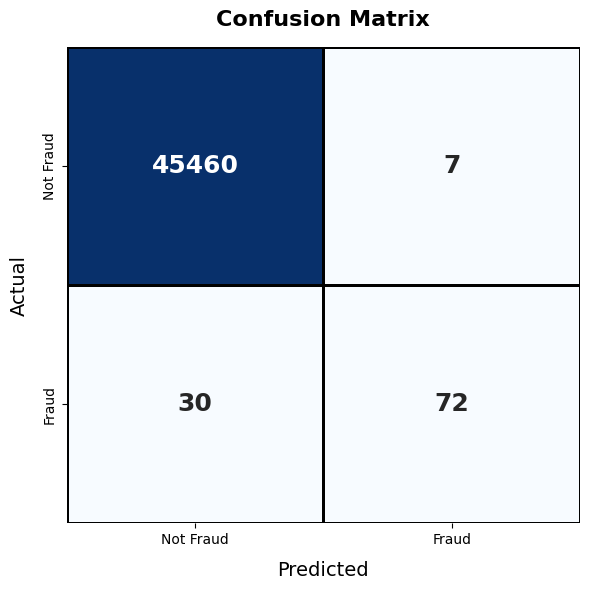

In [16]:
# Generate the confusion matrix
cm = pd.crosstab(
    valid_df[target].values, 
    predictions, 
    rownames=['Actual'], 
    colnames=['Predicted']
)

# Create the plot
plt.figure(figsize=(6, 6))  
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap="Blues",
    linewidths=1,
    linecolor="black",
    cbar=False,
    xticklabels=['Not Fraud', 'Fraud'],
    yticklabels=['Not Fraud', 'Fraud'],
    annot_kws={"size": 18, "weight": "bold"}
)

# Add title and labels
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Predicted', fontsize=14, labelpad=10)
plt.ylabel('Actual', fontsize=14, labelpad=10)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Type I and Type II Errors:

##### It is important to note that confusion matrices are not ideal for evaluating results in cases of highly imbalanced datasets. In such scenarios, alternative metrics that consider both the sensitivity (true positive rate) and specificity (true negative rate) of the model are more appropriate. These metrics help minimize both Type I and Type II errors simultaneously.

##### Null Hypothesis (H₀): The transaction is not fraudulent.

##### Alternative Hypothesis (H₁): The transaction is fraudulent.

##### Type I Error: Occurs when the null hypothesis is rejected even though it is true. In this context, it means incorrectly classifying a legitimate transaction as fraudulent.

##### Cost of Type I Error: A valid transaction is mistakenly flagged as fraud, leading to its rejection.
##### Type II Error: Occurs when the null hypothesis is not rejected even though the alternative hypothesis is true. In this context, it means failing to identify a fraudulent transaction.

##### Cost of Type II Error: A fraudulent transaction is mistakenly classified as legitimate, allowing it to proceed undetected.

### Success Metrics

- **Accuracy**: The proportion of total predictions that were correct.
- **Precision**: The proportion of positive identifications that were actually correct (minimizes false positives).
- **Recall (Sensitivity)**: The proportion of actual positives that were correctly identified (minimizes false negatives).
- **F1 Score**: The harmonic mean of precision and recall, providing a balance between the two.
- **ROC-AUC Score**: Measures the model's ability to distinguish between classes across all thresholds. A higher ROC-AUC indicates better overall classification performance, especially important for imbalanced datasets.
- **Classification Report**: A detailed summary including precision, recall, F1-score, and support for each class.

These metrics provide a more comprehensive view of model performance, especially for imbalanced datasets like fraud detection.

In [ ]:
# Calculate and print evaluation metrics
accuracy = accuracy_score(valid_df[target].values, predictions)
precision = precision_score(valid_df[target].values, predictions)
recall = recall_score(valid_df[target].values, predictions)
f1 = f1_score(valid_df[target].values, predictions)
roc_auc = roc_auc_score(valid_df[target].values, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(valid_df[target].values, predictions, target_names=["Not Fraud", "Fraud"]))

Accuracy: 0.9992
Precision: 0.9114
Recall: 0.7059
F1 Score: 0.7956
ROC-AUC Score: 0.8529

Classification Report:
               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     45467
       Fraud       0.91      0.71      0.80       102

    accuracy                           1.00     45569
   macro avg       0.96      0.85      0.90     45569
weighted avg       1.00      1.00      1.00     45569



### Explanation of Evaluation Metrics

The following metrics are used to evaluate the performance of the Random Forest classifier on the fraud detection task:

- **Accuracy**: The proportion of total predictions that were correct. In imbalanced datasets, accuracy can be misleading, as a model can achieve high accuracy by simply predicting the majority class.

- **Precision**: The proportion of positive predictions (fraud) that were actually correct. High precision means that when the model predicts fraud, it is usually correct. Important when the cost of a false positive is high.

- **Recall (Sensitivity)**: The proportion of actual fraud cases that were correctly identified. High recall means the model detects most frauds. Important when missing a fraud case is costly.

- **F1 Score**: The harmonic mean of precision and recall. It balances the trade-off between precision and recall, especially useful for imbalanced datasets.

- **ROC-AUC Score**: Measures the model's ability to distinguish between classes across all thresholds. A higher ROC-AUC indicates better overall performance.

- **Classification Report**: Provides a detailed breakdown of precision, recall, F1-score, and support for each class (fraud and not fraud).

**Note:** In fraud detection, recall and ROC-AUC are often prioritized, as it is crucial to identify as many fraudulent transactions as possible, even if it means accepting some false positives.